In [1]:
#basic python manipulation libraries
import numpy as np
import pandas as pd
from numpy import genfromtxt

#machine learning models and data splitting
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neighbors import KNeighborsRegressor 

#model metrics
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#export models to reuse later
from sklearn.externals import joblib

#plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()  

#plotly ID
plotly.tools.set_credentials_file(username='msoler96', api_key='cXQo3QCfIo3ggpjEgf4u')

#for a more comfortable working environment
import warnings
warnings.filterwarnings('ignore')
%load_ext autotime

# Pre-processing data

In [2]:
#import data
raw_data = pd.read_csv('data/trainingData.csv')

time: 2.17 s


In [3]:
#drop duplicates
raw_data.drop_duplicates(inplace=True) 

#calculate columns that have a mean of 100 to remove them later
mean100_cols = [i for i in np.arange(0,520,1) if raw_data.iloc[:,i].values.mean() == 100 ]

#calculate columns labels that have a mean of 100 to remove them later
col_labels = [raw_data.columns[i] for i in mean100_cols]
    
#delete columns with mean 100
raw_data.drop(columns=col_labels, axis=1, inplace=True)
raw_data = raw_data.reset_index(drop=True)

#export columns that have been removed
pd.Series(col_labels).to_csv('data/remove_cols.csv', index=False) 

time: 606 ms


In [4]:
#create a preprocessing formula so the process can be applied to any dataset (traning and validation and competition)
def preprocessing(df):
    '''This function applies the same preprocessing to any dataframe fed into it. This will be helpful later
    on since a validation and a competition set will be fed'''
    
    #if value == 100, change it to -105
    df.replace(100, -105, inplace=True)
    
    #know the WAP columns
    global cols
    cols = [col for col in df.columns if col not in ['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP']]
    
    #add 105 to all WAP values to they are in a 0-105 scale
    df[cols] += 105
    
    #add a column which counts the occurrences of non 0 signals

    signal = []
    for i in range(len(df)):
        a = df.loc[i,cols].value_counts()
        signal.append(sum(a)-a[0])
    
    df = df.assign(SIGNALCOUNT = signal)
    return df

time: 28.1 ms


In [5]:
clean_data = preprocessing(raw_data)

time: 39.9 s


In [6]:
clean_data.to_csv('data/ready.csv', index=False)

time: 10.2 s


# Data Exploration

In [7]:
array = clean_data[cols].values.flatten()

time: 260 ms


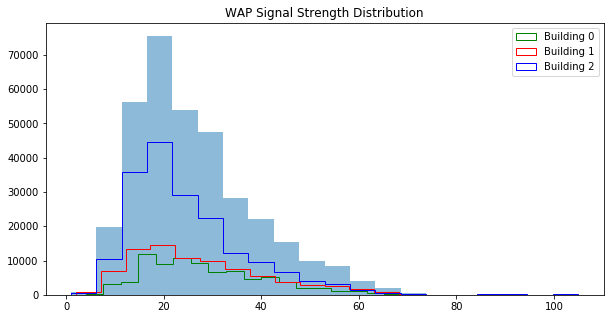

time: 1.2 s


In [8]:
plt.figure(figsize=(10,5))
plt.title('WAP Signal Strength Distribution')
plt.hist(array[np.where(array>0)], bins=20, alpha=0.5)
for i in range(3):
    color = ['green', 'red', 'blue']
    f = clean_data[cols[:-1]][clean_data['BUILDINGID'] == i].values.flatten()
    plt.hist(f[np.where(f>0)], bins=20, color = color[i], histtype='step')
    plt.legend(['Building 0', 'Building 1', 'Building 2']);


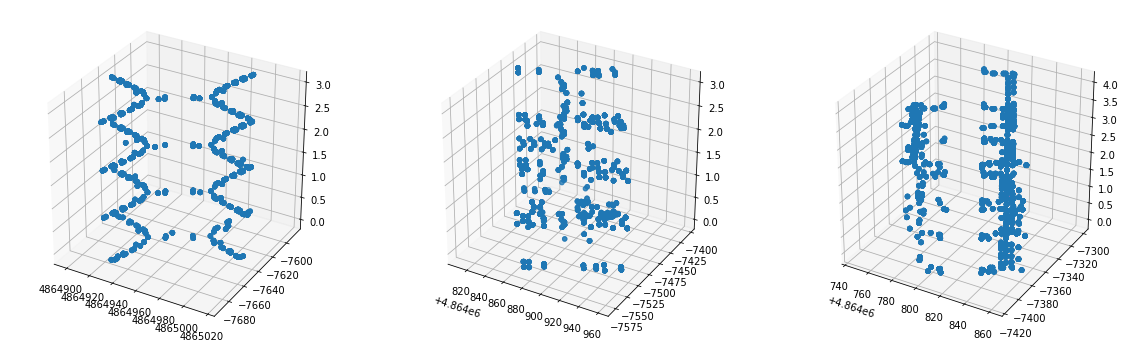

time: 3.27 s


In [9]:
fig = plt.figure(figsize=(20,6))

building = range(3)

for i in building:
    ax = fig.add_subplot(1,3,i+1,projection='3d')
    
    xdata = clean_data['LATITUDE'][clean_data['BUILDINGID'] == i]
    ydata = clean_data['LONGITUDE'][clean_data['BUILDINGID'] == i]
    zdata = clean_data['FLOOR'][clean_data['BUILDINGID'] == i]

    ax.scatter3D(xdata, ydata, zdata)

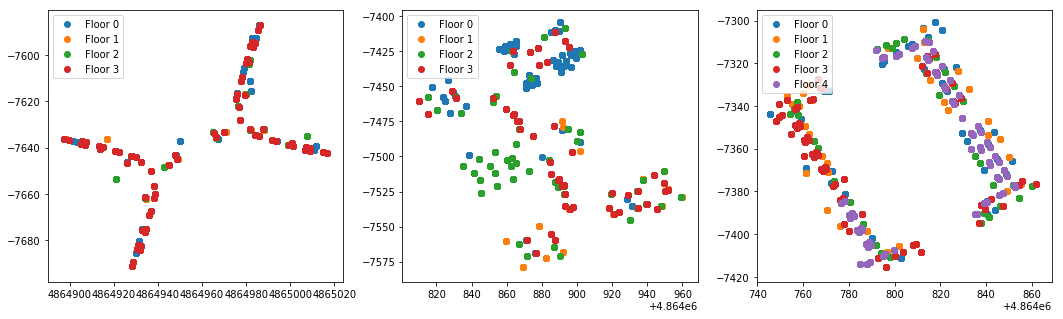

time: 961 ms


In [10]:
plt.figure(figsize=(18,5))

for b in range(3):
    plt.subplot(1,3,b+1)
    for i in np.unique(clean_data['FLOOR'][clean_data['BUILDINGID'] == b]):
        xdata = clean_data['LATITUDE'][clean_data['BUILDINGID'] == b][clean_data['FLOOR'] == i]
        ydata = clean_data['LONGITUDE'][clean_data['BUILDINGID'] == b][clean_data['FLOOR'] == i]
        plt.scatter(xdata, ydata)
        labels = ['Floor %s' %str(i) for i in np.unique(clean_data['FLOOR'][clean_data['BUILDINGID'] == b])]
        plt.legend(labels, loc=2)

In [11]:
def plot3d(clean_data):
    """This function creates a basic 3d plot for the buildings"""
    trace0 = go.Scatter3d(
        x=clean_data['LATITUDE'][clean_data['BUILDINGID'] == 0],
        y=clean_data['LONGITUDE'][clean_data['BUILDINGID'] == 0],
        z=clean_data['FLOOR'][clean_data['BUILDINGID'] == 0],
        mode='markers',
        marker=dict(
            size=4,
            color='blue',                
            opacity=0.8
        )
    )

    trace1 = go.Scatter3d(
        x=clean_data['LATITUDE'][clean_data['BUILDINGID'] == 1],
        y=clean_data['LONGITUDE'][clean_data['BUILDINGID'] == 1],
        z=clean_data['FLOOR'][clean_data['BUILDINGID'] == 1],
        mode='markers',
        marker=dict(
            size=4,
            color='red',                
            opacity=0.8
        )
    )

    trace2 = go.Scatter3d(
        x=clean_data['LATITUDE'][clean_data['BUILDINGID'] == 2],
        y=clean_data['LONGITUDE'][clean_data['BUILDINGID'] == 2],
        z=clean_data['FLOOR'][clean_data['BUILDINGID'] == 2],
        mode='markers',
        marker=dict(
            size=4,
            color= 'green',                
            opacity=0.8
        )
    )

    datas = [trace0, trace1,trace2]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),showlegend=False
    )

    fig = go.Figure(data=datas, layout=layout)
    return py.iplot(fig, filename='simple-3d-scatter')

time: 45.8 ms


In [12]:
plot3d(clean_data)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~msoler96/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


time: 9.64 s


# Machine Learning Model Functions

## Classification

In [13]:
#create a function for random forest classification
def classification(X, y, title, model, test_size = 0.3, random_state = 42):
    """This function splits the data into train and test and fits it in a random forest classifier 
    to the data provided, analysing its errors (Accuracy and Kappa). Also as this is classification,
    the function will output a confusion matrix"""
    
    #Split data in train and test, as well as predictors (X) and targets, (y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    #import desired machine learning algorithm
    if model.lower() in  ['rf','random_forest','random forest']:
        mod = 'RF'
        base_model = RandomForestClassifier(random_state=random_state)
    elif model.lower() in ['knn','k-nn']:
        mod = 'KNN'
        base_model = KNeighborsClassifier()
    else:
        print('Model not found. Try: "KNN", "RF"')
            
    #Train the model
    base_model.fit(X_train,y_train)

    #make predictions on test set
    y_pred=base_model.predict(X_test)
    
    #save the model
    name = 'models/' + title + '_' + mod + '_train.sav'
    joblib.dump(base_model, name)
    
    #Print Accuracy and Kappa
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Kappa:",metrics.cohen_kappa_score(y_test, y_pred))
    
    #create confusion matrix
    labs = [y_test[i][0] for i in range(len(y_test))]
    cm = pd.DataFrame(confusion_matrix(labs, y_pred))
    cm.columns = ['Actual %s' %str(i) for i in np.unique(y_pred)]
    cm.index = ['Predicted %s' %str(i) for i in np.unique(y_pred)]
    return cm

time: 123 ms


## Regression

In [14]:
#create a function for plotting
def double_plot(y, RMSE):
    """This function creates a scatter plot and a histogram on its y_right axis,being able to see how errors 
    are distributed. It has horizontal lines showing the observations outside RMSE and 2RMSE """ 
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width
    rect_scatter = [left, bottom, width, height]
    rect_histy = [left_h, bottom, 0.2, height]
    
    # start with a rectangular Figure
    plt.figure(1, figsize=(15, 8))
    axScatter = plt.axes(rect_scatter)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHisty.yaxis.set_major_formatter(nullfmt)

    # scatter plot:
    x = np.arange(0,len(y),1)
    axScatter.scatter(x, y, s=2)
    axScatter.set_xlim((0, max(x)))
    axScatter.hlines([RMSE,-RMSE], 0, max(x), colors='red', linestyles='dashdot', label='±RMSE')
    axScatter.hlines([2*RMSE,-2*RMSE], 0, max(x), colors='black', linestyles='dashdot', label='± 2*RMSE')
    axScatter.legend(loc=1)
    
    #histogram in y axis
    counts, bins, bars = axHisty.hist(y, bins=100, orientation='horizontal')
    axHisty.hlines([RMSE,-RMSE], 0, max(counts), colors='red', linestyles='dashdot', label='±RMSE')
    axHisty.hlines([2*RMSE,-2*RMSE], 0, max(counts), colors='black', linestyles='dashdot', label='±2*RMSE')
    plt.legend(loc=1)
    axHisty.set_ylim(axScatter.get_ylim())
    
    plt.show()

time: 159 ms


In [15]:
#create a function for random forest regression
def regression(X, y, title, model, test_size = 0.3, random_state = 42):
    """This function splits the data into train and test and fits it in a random forest regressor 
    to the data provided, analysing its errors (MAE, MSE, RMSE, R2). """ 
    
    #Split data in train and test, as well as predictors (X) and targets, (y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    #import desired machine learning algorithm
    if model.lower() in  ['rf','random_forest','random forest']:
        mod = 'RF'
        base_model = RandomForestRegressor(random_state=random_state)
    elif model.lower() in ['knn','k-nn']:
        mod = 'KNN'
        base_model = KNeighborsRegressor()
    else:
        print('Model not found. Try: "KNN", "RF"')
        
    #Train the model
    base_model.fit(X_train,y_train)

    #make predictions on test set
    y_pred=base_model.predict(X_test)
    
    #save the model
    name = 'models/' + title + '_' + mod + '_train.sav'
    joblib.dump(base_model, name)
    
    #Calculate regression errors
    MAE = mean_absolute_error(y_test, y_pred) 
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = MSE ** 0.5 #rmse(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    
    #generate clean arrays of numbers for plotting in next step
    y1 = [y_test[i][0] for i in range(len(y_test))] #target
    y2 = y_pred #predictions
    y = [v2 - v1 for v2, v1 in zip(y2,y1)]
    
    if mod == 'RF':
        double_plot(y, RMSE)
        pd.DataFrame({'REAL':y1, 'PRED':y2}).to_csv('predictions/train_'+ title + model + '.csv', index=False)
        #export values for plots later
        pd.Series(y).to_csv('errors/plot_'+title+model+'.csv', index=False)
    else:
        z = [y[i][0] for i in range(len(y))]
        double_plot(z, RMSE)
        pd.DataFrame({'REAL':y1, 'PRED':y2.flatten()}).to_csv('predictions/train_'+ title + model + '.csv', index=False)
        #export values for plots later
        pd.Series(z).to_csv('errors/plot_'+title+model+'.csv', index=False)
    
    
    #Get index of values that the absolute error is greater than it's MSE
    values_greater_2RMSE = list(filter(lambda x: x > 2*RMSE, y))
    vals = [ y.index(i) for i in values_greater_2RMSE]
    pd.Series(vals).to_csv('index/index_' + title + model + '.csv', index=False) 

    #display such errors
    LON_errors = pd.DataFrame({'MAE':[MAE], 'MSE':[MSE], 'RMSE':[RMSE], 'R^2':[R2]})
    return LON_errors

time: 223 ms


# Training

In [16]:
#import the pre-processed data
data = pd.read_csv('data/ready.csv')

time: 1.78 s


## *BUILDING *

In [17]:
# X is the feature set and y is the target
ncols = list(range(465)) + [len(data.columns)-1]
X = data.iloc[:,ncols].values # WAP values to predict building 
y = data.loc[:,['BUILDINGID']].values

time: 86.6 ms


### Random Forest

In [18]:
classification(X,y, 'building', 'RF')

Accuracy: 0.9986183074265976
Kappa: 0.9978530921776171


,Actual 0,Actual 1,Actual 2
Predicted 0,1642,0,0
Predicted 1,0,1500,8
Predicted 2,0,0,2640


time: 1 s


### KNN

In [19]:
classification(X,y,'building','KNN')

Accuracy: 0.9981001727115717
Kappa: 0.9970509416150338


,Actual 0,Actual 1,Actual 2
Predicted 0,1642,0,0
Predicted 1,0,1508,0
Predicted 2,0,11,2629


time: 36.3 s


## *FLOOR*

In [20]:
#The feature set (X) will include WAPs as well as Building ID to improve performance
cols_floor = [i for i in range(465)] + [468] + [len(data.columns)-1]

# X is the feature set and y is the target
X = data.iloc[:,cols_floor].values
y = data.loc[:,['FLOOR']].values

time: 94.5 ms


### Random Forest

In [21]:
classification(X, y, 'floor', 'RF')

Accuracy: 0.9956822107081175
Kappa: 0.9943613593833466


,Actual 0,Actual 1,Actual 2,Actual 3,Actual 4
Predicted 0,1301,0,0,0,0
Predicted 1,4,1474,2,0,0
Predicted 2,1,8,1289,4,0
Predicted 3,0,0,6,1487,0
Predicted 4,0,0,0,0,214


time: 818 ms


### KNN

In [22]:
classification(X, y, 'floor', 'KNN')

Accuracy: 0.9972366148531951
Kappa: 0.9963911804564035


,Actual 0,Actual 1,Actual 2,Actual 3,Actual 4
Predicted 0,1300,1,0,0,0
Predicted 1,4,1475,1,0,0
Predicted 2,3,1,1292,6,0
Predicted 3,0,0,0,1493,0
Predicted 4,0,0,0,0,214


time: 36.3 s


## *LONGITUDE * 

In [23]:
#The feature set (X) will include WAPs as well as dummyfied Building ID to improve performance
cols_long = [i for i in range(465)] + [468] 

# X is the feature set and y is the target
X = data.iloc[:,cols_long].values
y = data.loc[:,['LONGITUDE']].values

time: 64.7 ms


### Random Forest

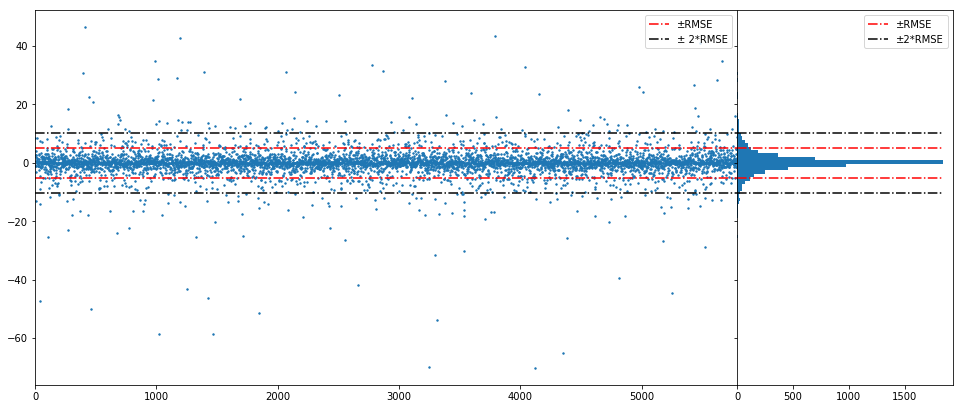

,MAE,MSE,RMSE,R^2
0,2.521853,26.198238,5.118421,0.998322


time: 4.86 s


In [24]:
regression(X, y, 'longitude', 'RF')

### KNN

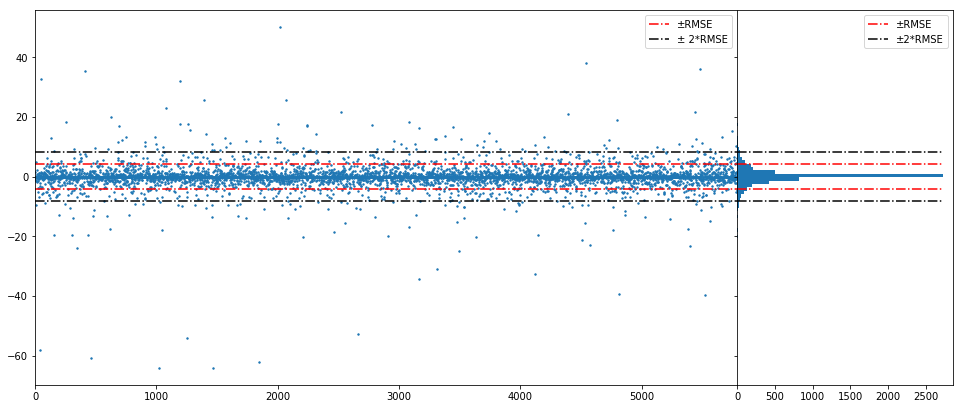

,MAE,MSE,RMSE,R^2
0,1.786141,16.998377,4.122909,0.998911


time: 36.5 s


In [25]:
regression(X, y, 'longitude', 'KNN')

## *LATITUDE *

In [26]:
#The feature set (X) will include WAPs as well as dummyfied Building ID to improve performance and LONGITUDE
cols_lat = [i for i in range(465)] + [468] + [465] 

# X is the feature set and y is the target
X = data.iloc[:,cols_lat].values
y = data.loc[:,['LATITUDE']].values

time: 125 ms


### Random Forest

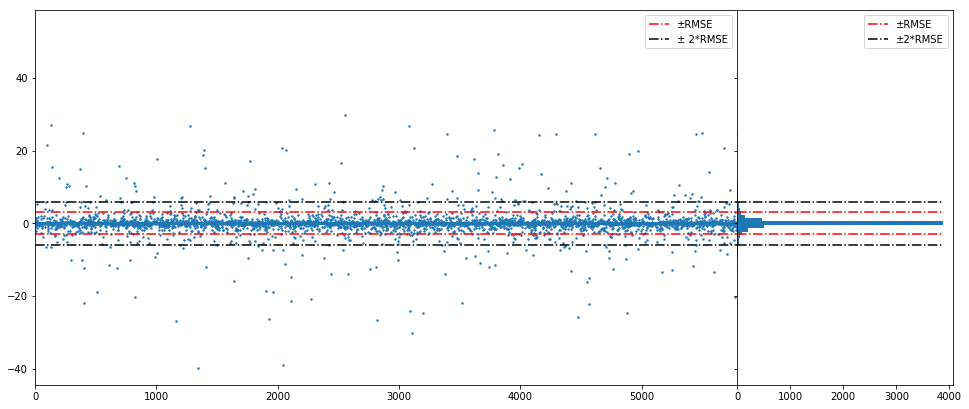

,MAE,MSE,RMSE,R^2
0,1.003145,8.998434,2.999739,0.998031


time: 4.89 s


In [27]:
regression(X,y,'latitude', 'RF')

### KNN

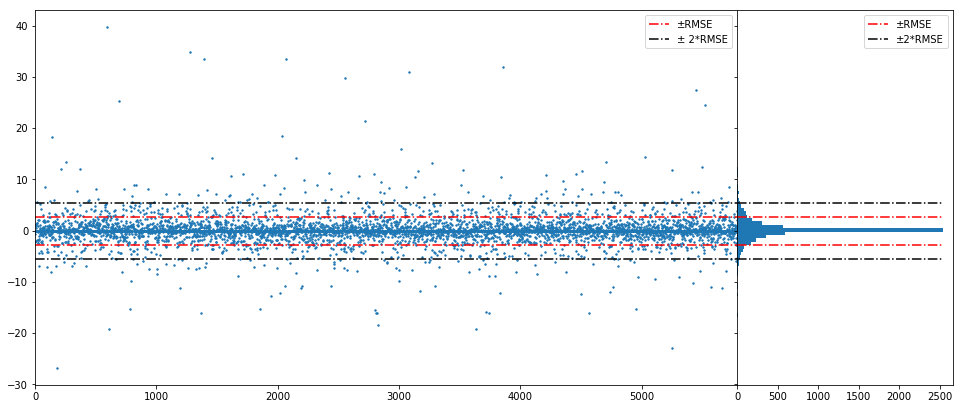

,MAE,MSE,RMSE,R^2
0,1.304678,7.504445,2.739424,0.998358


time: 11.6 s


In [28]:
regression(X,y,'latitude', 'KNN')

# Error Visualization: Where do models fail?

## Errors greater than 2RMSE in the map

In [29]:
lat_ind = pd.read_csv('index/index_latitudeRF.csv', header=None)
lat_ind.columns = ['INDEX']
lon_ind = pd.read_csv('index/index_longitudeRF.csv', header=None)
lon_ind.columns = ['INDEX']
index = np.unique(lat_ind['INDEX'].tolist() + lon_ind['INDEX'].tolist()).tolist()

time: 17.2 ms


In [30]:
err_lon_rf = pd.read_csv('predictions/train_longituderf.csv')
err_lat_rf = pd.read_csv('predictions/train_latituderf.csv')

time: 20.2 ms


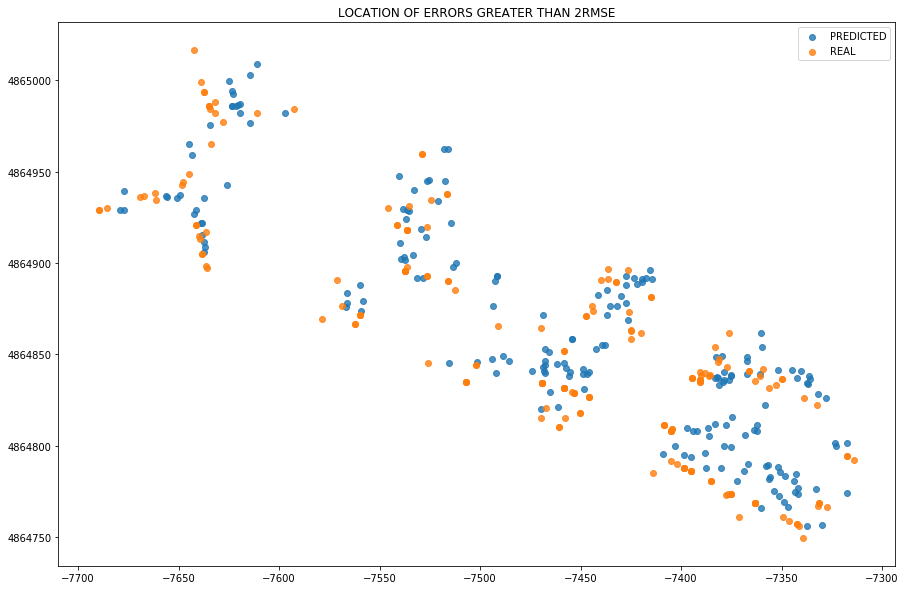

time: 336 ms


In [31]:
plt.figure(figsize=(15,10))
plt.title('LOCATION OF ERRORS GREATER THAN 2RMSE')
plt.scatter(err_lon_rf.iloc[index,0], err_lat_rf.iloc[index,0], alpha=0.8)
plt.scatter(err_lon_rf.iloc[index,1], err_lat_rf.iloc[index,1], alpha=0.8)
plt.legend(['PREDICTED', 'REAL'])

##  Comparing Residuals


In [32]:
rf_lon = pd.read_csv('errors/plot_longitudeRF.csv', header=None)
rf_lat = pd.read_csv('errors/plot_latitudeRF.csv', header=None)
knn_lon = pd.read_csv('errors/plot_longitudeknn.csv', header=None)
knn_lat = pd.read_csv('errors/plot_latitudeKNN.csv', header=None)

time: 29.4 ms


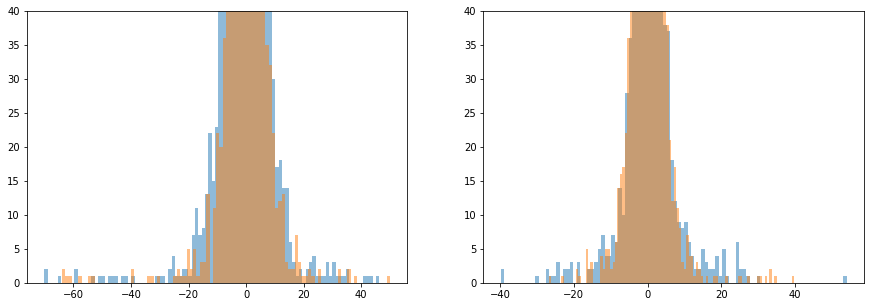

time: 1.37 s


In [33]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1.set_ylim([0,40])
n, x, _ = ax1.hist(rf_lon.values, alpha=0.5, bins=100)
ax1.hist(knn_lon.values, alpha=0.5, bins=100)
ax2 = plt.subplot(122)
ax2.set_ylim([0,40])
ax2.hist(rf_lat.values, alpha=0.5, bins=100)
ax2.hist(knn_lat.values, alpha=0.5, bins=100);

## Variance 

In [34]:
index_ok = [x for x in list(range(len(clean_data))) if x not in  index]

time: 94.2 ms


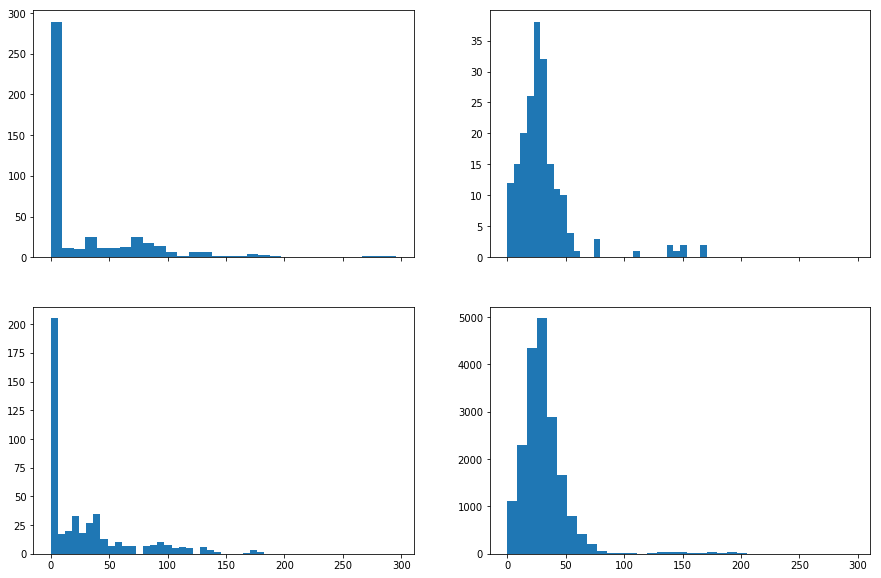

time: 1.31 s


In [35]:
fig, ax = plt.subplots(2,2, sharex=True, figsize=(15, 10))
#variance of WAP values (columns)
ax[0,0].hist(data.iloc[index,0:465].var(axis=0).values, bins=30)
#variance of each observations (rows)
ax[0,1].hist(data.iloc[index,0:465].var(axis=1).values, bins=30)
#variance of WAP values (columns)
ax[1,0].hist(data.iloc[index_ok,0:465].var(axis=0).values,bins=30)
#variance of each observations (rows)
ax[1,1].hist(data.iloc[index_ok,0:465].var(axis=1).values,bins=30);

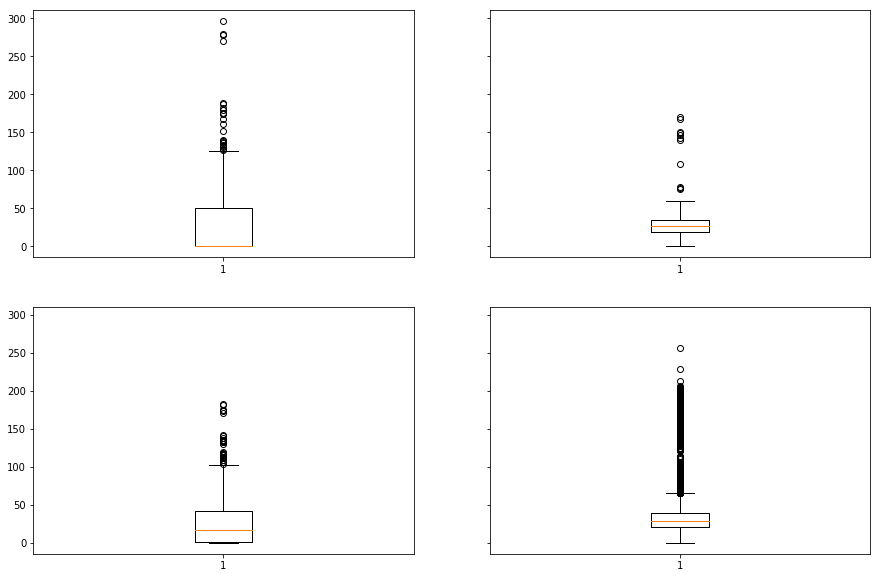

time: 699 ms


In [36]:
fig, ax = plt.subplots(2,2, sharey=True,figsize=(15, 10))
#variance of WAP values (columns)
ax[0,0].boxplot(data.iloc[index,0:465].var(axis=0).values)
#variance of each observations (rows)
ax[0,1].boxplot(data.iloc[index,0:465].var(axis=1).values)
#variance of WAP values (columns)
ax[1,0].boxplot(data.iloc[index_ok,0:465].var(axis=0).values)
#variance of each observations (rows)
ax[1,1].boxplot(data.iloc[index_ok,0:465].var(axis=1).values);

# Validation

In [37]:
#import validation data
val_data = pd.read_csv('data/validationData.csv')

#import list of columns to remove from validation data
remove = pd.read_csv('data/remove_cols.csv', header=None)

time: 180 ms


In [38]:
#create a list of columns
cols = remove[0].tolist()

#use that list of columns to remove them from the validation dataset
val_data.drop(columns=cols, axis=1, inplace=True)

time: 10.7 ms


In [39]:
val_data = preprocessing(val_data)

time: 2.63 s


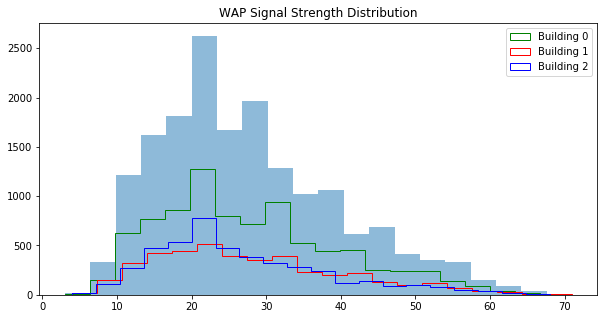

time: 329 ms


In [65]:
array = val_data[cols].values.flatten()
plt.figure(figsize=(10,5))
plt.title('WAP Signal Strength Distribution')
plt.hist(array[np.where(array>0)], bins=20, alpha=0.5)
for i in range(3):
    color = ['green', 'red', 'blue']
    f = val_data[cols[:-1]][val_data['BUILDINGID'] == i].values.flatten()
    plt.hist(f[np.where(f>0)], bins=20, color = color[i], histtype='step')
    plt.legend(['Building 0', 'Building 1', 'Building 2']);

## Validation Machine Learning Functions

In [40]:
def classification_val(X_val, y_val, model, export_name):
    #make the predictions with the loaded model
    y_pred=model.predict(X_val)
    
    #export predictions for later usage
    pd.Series(y_pred).to_csv('predictions/' + export_name + '.csv', index=False)
    
    #print Accuracy and Kappa error metrics
    print("Accuracy: %5.3f" %(metrics.accuracy_score(y_val, y_pred)))
    print("Kappa: %5.3f"%(metrics.cohen_kappa_score(y_val, y_pred)))
    
    #create confusion matrix
    labs = [y_val[i][0] for i in range(len(y_val))]
    cm = pd.DataFrame(confusion_matrix(labs, y_pred))
    cm.columns = ['Actual %s' %str(i) for i in np.unique(y_val)]
    cm.index = ['Predicted %s' %str(i) for i in np.unique(y_val)]
    
    #print errors in a pandas datagrame
    LON_errors = pd.DataFrame({'Accuracy':[metrics.accuracy_score(y_val, y_pred)], \
                               'Kappa':[metrics.cohen_kappa_score(y_val, y_pred)],})
    
    #export errors
    LON_errors.to_csv('errors/'+'class_' + export_name + '.csv', index=False)
    return cm

time: 60 ms


In [41]:
def regression_val(X_val, y_val, model, export_name):
    #make the predictions with the loaded model
    y_pred=model.predict(X_val)
    
    #Calculate regression errors
    MAE = mean_absolute_error(y_val, y_pred) 
    MSE = mean_squared_error(y_val, y_pred)
    RMSE = MSE ** 0.5
    R2 = r2_score(y_val, y_pred)
    
    #generate clean arrays of numbers for plotting in next step
    y1 = [y_val[i][0] for i in range(len(y_val))] #target
    y2 = y_pred #predictions
    y = [v2 - v1 for v2, v1 in zip(y2,y1)]
    abs_error = [v2 - v1 for v2, v1 in zip(y2,y1)]

    #plot absolute errors 
    if export_name[-2:].lower() in  ['rf']:
        mod = 'RF'
    elif export_name[-3:].lower() in ['knn']:
        mod = 'KNN'
    else:
        print('Model not found. Try: "KNN", "RF"')
    
    if mod == 'RF':
        double_plot(y, RMSE)
        #export values for plots later
        pd.Series(y).to_csv('errors/plot_'+'val_'+export_name+'.csv', index=False)
    else:
        z = [y[i][0] for i in range(len(abs_error))]
        double_plot(z, RMSE)
        #export values for plots later
        pd.Series(z).to_csv('errors/plot_'+'val_'+export_name+'.csv', index=False)
    
    #export predictions for later usage
    pd.Series(y1).to_csv('predictions/' + export_name + '.csv', index=False)
    
    #print errors in a pandas datagrame
    LON_errors = pd.DataFrame({'MAE':[MAE], 'MSE':[MSE], 'RMSE':[RMSE], 'R^2':[R2]})
    
    #export errors
    LON_errors.to_csv('errors/' + 'errors_' + export_name + '.csv', index=False)
    return LON_errors

time: 111 ms


## *BUILDING*

In [42]:
# X_val is the feature set and y_val is the target
X_val = val_data.iloc[:,ncols].values 
y_val = val_data.loc[:,['BUILDINGID']].values

#load trained models
building_rf = joblib.load('models/building_rf_train.sav')
building_knn = joblib.load('models/building_knn_train.sav')

time: 283 ms


### Random Forest

In [43]:
classification_val(X_val, y_val, building_rf, 'building_rf')

Accuracy: 0.996
Kappa: 0.994


,Actual 0,Actual 1,Actual 2
Predicted 0,535,1,0
Predicted 1,2,304,1
Predicted 2,0,0,268


time: 41.6 ms


### KNN

In [44]:
classification_val(X_val, y_val, building_knn, 'building_knn')

Accuracy: 0.997
Kappa: 0.996


,Actual 0,Actual 1,Actual 2
Predicted 0,535,1,0
Predicted 1,0,307,0
Predicted 2,0,2,266


time: 7.73 s


## *FLOOR*

In [45]:
#create new dataframes, since predictions will be attached to it depending on the model
val_data_rf = val_data
val_data_knn = val_data

#import building predictions
array_rf = pd.read_csv('predictions/building_rf.csv', header=None)
array_rf.columns = ['BUILDING_RF_PREDICTIONS']
array_knn = pd.read_csv('predictions/building_knn.csv', header=None)
array_knn.columns = ['BUILDING_KNN_PREDICTIONS']

#append to val_data
val_data_rf = pd.concat([val_data_rf, array_rf], axis=1)
val_data_knn = pd.concat([val_data_knn, array_knn], axis=1)

# X_val is the feature set and y_val is the target
X_val_rf = val_data_rf.iloc[:,cols_floor].values
y_val_rf = val_data_rf.loc[:,['FLOOR']].values

# X_val is the feature set and y_val is the target
X_val_knn = val_data_knn.iloc[:,cols_floor].values
y_val_knn = val_data_knn.loc[:,['FLOOR']].values

#load trained models
floor_rf = joblib.load('models/floor_rf_train.sav')
floor_knn = joblib.load('models/floor_knn_train.sav')

time: 405 ms


### Random Forest

In [46]:
classification_val(X_val_rf, y_val_rf, floor_rf, 'floor_rf')

Accuracy: 0.882
Kappa: 0.836


,Actual 0,Actual 1,Actual 2,Actual 3,Actual 4
Predicted 0,120,10,2,0,0
Predicted 1,17,394,49,2,0
Predicted 2,3,18,275,10,0
Predicted 3,0,0,10,162,0
Predicted 4,2,0,0,8,29


time: 49.2 ms


### KNN

In [47]:
classification_val(X_val_knn, y_val_knn, floor_knn, 'floor_knn')

Accuracy: 0.901
Kappa: 0.862


,Actual 0,Actual 1,Actual 2,Actual 3,Actual 4
Predicted 0,117,7,7,1,0
Predicted 1,9,403,46,4,0
Predicted 2,2,8,281,15,0
Predicted 3,0,1,3,168,0
Predicted 4,2,0,0,5,32


time: 7.78 s


## *LONGITUDE*

In [48]:
#The feature set (X) will include WAPs as well as dummyfied Building ID to improve performance

# X_val is the feature set and y_val is the target
X_val_rf = val_data_rf.iloc[:,cols_long].values
y_val_rf = val_data_rf.loc[:,['LONGITUDE']].values

# X_val is the feature set and y_val is the target
X_val_knn = val_data_knn.iloc[:,cols_long].values
y_val_knn = val_data_knn.loc[:,['LONGITUDE']].values

#load trained models
lon_rf = joblib.load('models/longitude_rf_train.sav')
lon_knn = joblib.load('models/longitude_knn_train.sav')

time: 310 ms


### Random Forest

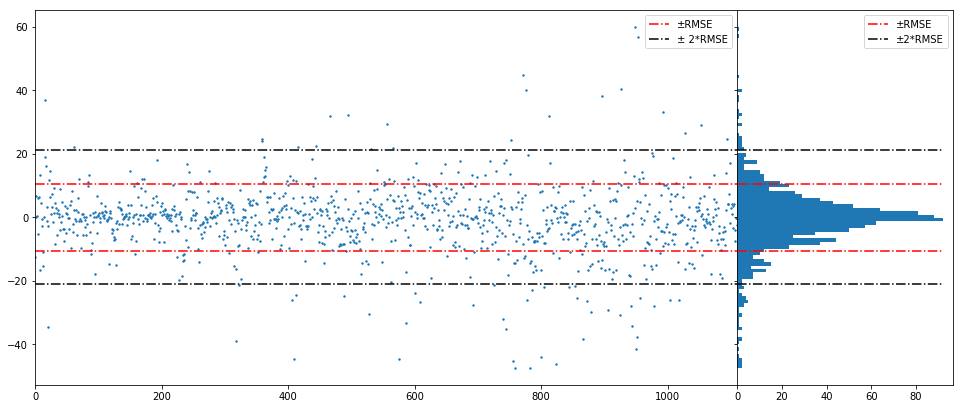

,MAE,MSE,RMSE,R^2
0,6.941596,111.161328,10.543307,0.9923


time: 508 ms


In [49]:
regression_val(X_val_rf, y_val_rf, lon_rf, 'longitude_rf')

### KNN

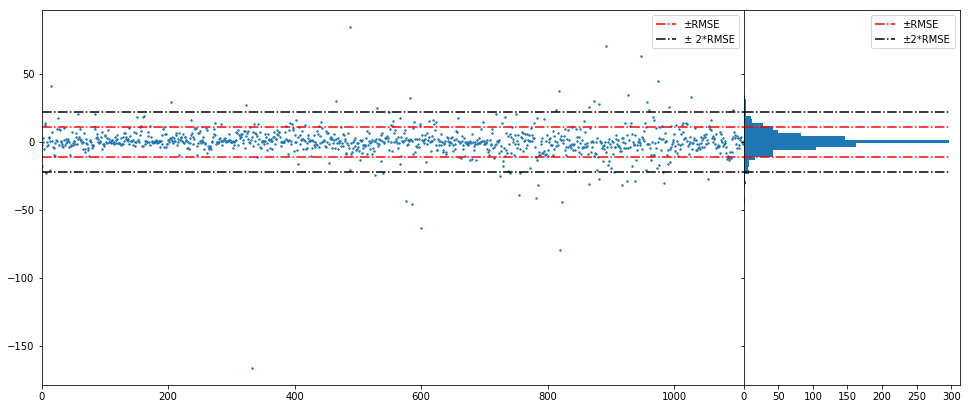

,MAE,MSE,RMSE,R^2
0,5.891743,121.496299,11.022536,0.991585


time: 8.44 s


In [50]:
regression_val(X_val_knn, y_val_knn, lon_knn, 'longitude_knn')

## *LATITUDE*

In [51]:
#import longitude predictions
array_rf = pd.read_csv('predictions/longitude_rf.csv', header=None)
array_rf.columns = ['LONGITUDE_RF_PREDICTIONS']
array_knn = pd.read_csv('predictions/longitude_knn.csv', header=None)
array_knn.columns = ['LONGITUDE_KNN_PREDICTIONS']

#append Longitude predictions to datasets
val_data_rf = pd.concat([val_data_rf, array_rf], axis=1)
val_data_knn = pd.concat([val_data_knn, array_knn], axis=1)

#The feature set (X) will include WAPs as well as dummyfied Building ID  and LONGITUDE to improve performance

# X_val is the feature set and y_val is the target
X_val_rf = val_data_rf.iloc[:,cols_lat].values
y_val_rf = val_data_rf.loc[:,['LATITUDE']].values

# X_val is the feature set and y_val is the target
X_val_knn = val_data_knn.iloc[:,cols_lat].values
y_val_knn = val_data_knn.loc[:,['LATITUDE']].values

#load trained models
lat_rf = joblib.load('models/latitude_rf_train.sav')
lat_knn = joblib.load('models/latitude_knn_train.sav')

time: 389 ms


### Random Forest

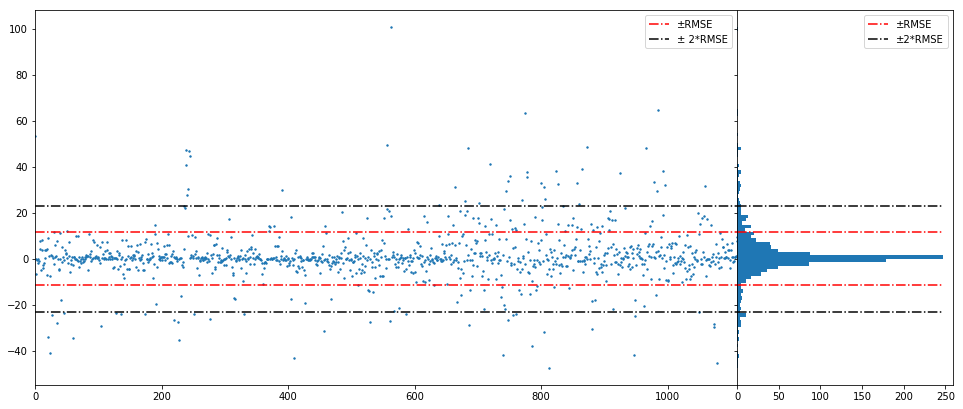

,MAE,MSE,RMSE,R^2
0,6.355077,133.454196,11.552238,0.972951


time: 524 ms


In [52]:
regression_val(X_val_rf, y_val_rf, lat_rf, 'latitude_rf')

### KNN

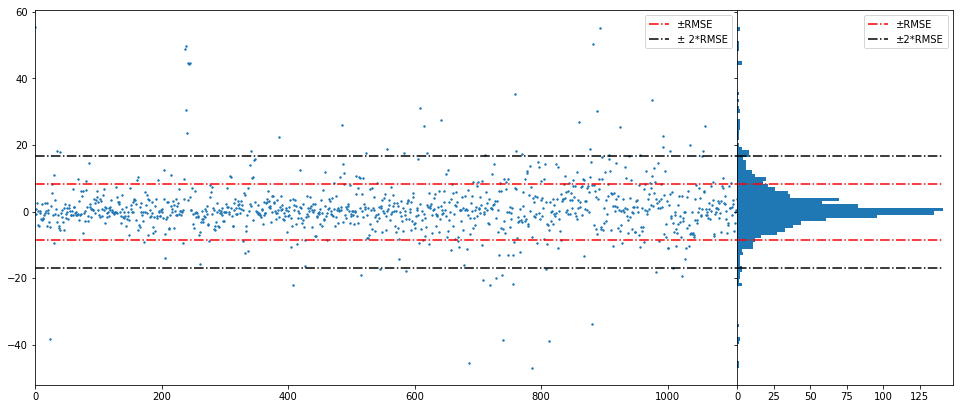

,MAE,MSE,RMSE,R^2
0,4.964965,70.910559,8.420841,0.985628


time: 2.71 s


In [53]:
regression_val(X_val_knn, y_val_knn, lat_knn, 'latitude_knn')

# Visual Evaluation of Validation Predictions

In [54]:
#import dynamically all data needed 
classification, regression = ['building', 'floor'], ['latitude', 'longitude']
models = ['rf', 'knn']

#loop through the features and models and import them accordingly
concat_r, concat_c = [], []
index_r, index_c = [], []
for m in models:
    for c,r in zip(classification, regression) :
        file_r, file_c = 'errors/'+'errors_' + r + '_' + m + '.csv', 'errors/'+'class_' + c + '_' + m + '.csv' #filename to import
        var_name_r, var_name_c = r + '_' + m  , c + '_' + m                  #variable name as string
        globals()[var_name_r], globals()[var_name_c] = pd.read_csv(file_r), pd.read_csv(file_c) #change string to variable name
        concat_r.append(globals()[var_name_r])
        concat_c.append(globals()[var_name_c])
        index_r.append(var_name_r)
        index_c.append(var_name_c)

time: 73 ms


In [55]:
#concaterate an error matrix for easy visualization and display it
class_errors = pd.concat(concat_c)
class_errors.index = index_c
class_errors

,Accuracy,Kappa
building_rf,0.996400,0.994308
floor_rf,0.882088,0.835614
building_knn,0.997300,0.995733
floor_knn,0.900990,0.862068


time: 15.8 ms


In [56]:
#concaterate an error matrix for easy visualization and display it
errors = pd.concat(concat_r)
errors.index = index_r
errors

,MAE,MSE,RMSE,R^2
latitude_rf,6.355077,133.454196,11.552238,0.972951
longitude_rf,6.941596,111.161328,10.543307,0.992300
latitude_knn,4.964965,70.910559,8.420841,0.985628
longitude_knn,5.891743,121.496299,11.022536,0.991585


time: 31.8 ms


## Error Visualization: Regression

In [57]:
lon_rf_err = pd.read_csv('errors/errors_longitude_rf.csv', header=None)

time: 4.9 ms


In [58]:
lon_rf_err

,0,1,2,3
0,MAE,MSE,RMSE,R^2
1,6.941595897081348,111.16132774346808,10.543307248841232,0.9923003956392723


time: 18.1 ms


In [59]:
#import dynamically all data needed 
elements = ['building', 'floor', 'latitude', 'longitude']
models = ['rf', 'knn']

#loop through the features and models and import them accordingly
for m in models:
    for e in elements:
        var_name = e + '_' + m
        file = 'predictions/' + e + '_' + m + '.csv'
        globals()[var_name] = pd.read_csv(file, header=None)

#Join Dataframes for RandomForest and KNN
#RF
RF = pd.concat([building_rf, floor_rf, latitude_rf, longitude_rf], axis=1)
RF.columns = ['BUILDINGID', 'FLOOR', 'LATITUDE', 'LONGITUDE']

#KNN
KNN = pd.concat([building_knn, floor_knn, latitude_knn, longitude_knn], axis=1)
KNN.columns = ['BUILDINGID', 'FLOOR', 'LATITUDE', 'LONGITUDE']

time: 48.8 ms


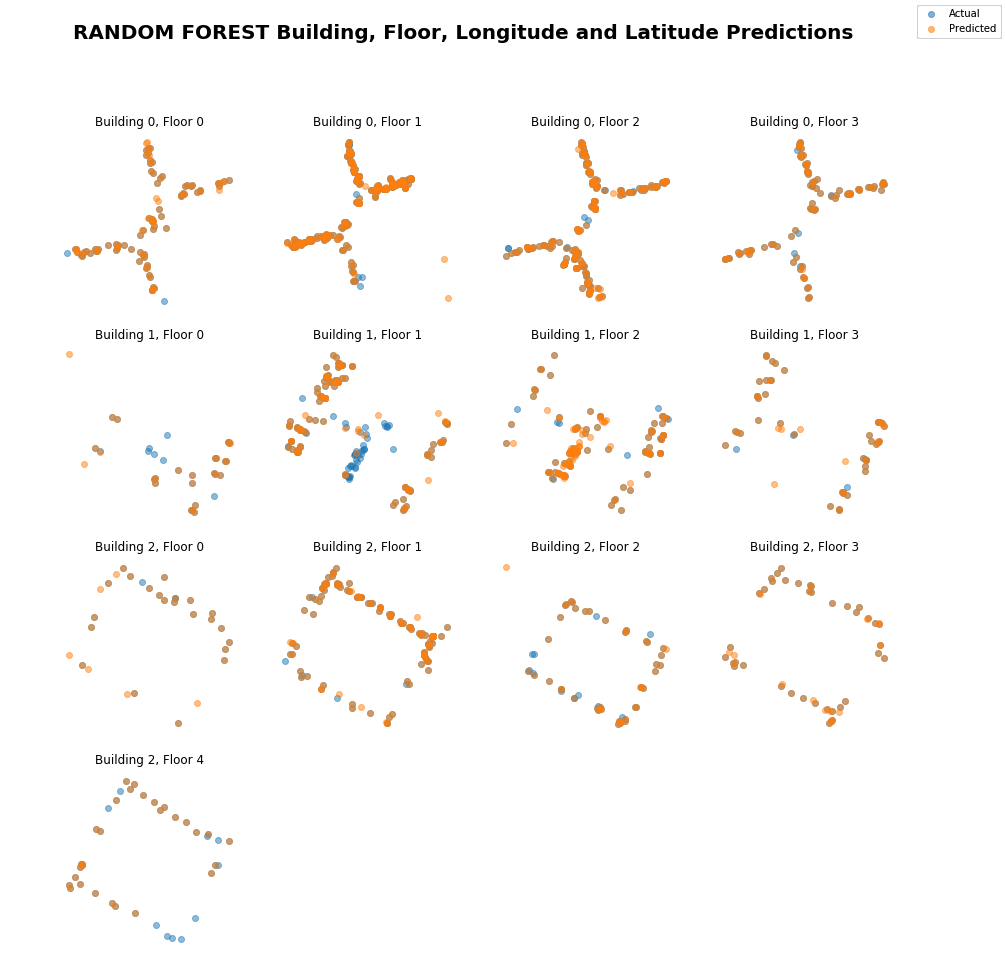

time: 1.76 s


In [60]:
#generate a matrix plot and superimpore Actual vs Predicted Latitude and Longitude spatial points
subplot_num = 0
fig = plt.figure(figsize=(15,15))
fig.suptitle('RANDOM FOREST Building, Floor, Longitude and Latitude Predictions', fontsize=20, fontweight='bold')
for i in range(3):
    for j in np.unique(RF['FLOOR'][RF['BUILDINGID'] == i]):
        x, y = val_data['LONGITUDE'][val_data['BUILDINGID'] == i][val_data['FLOOR'] == j], val_data['LATITUDE'][val_data['BUILDINGID'] == i][val_data['FLOOR'] == j]
        x_p, y_p = RF['LONGITUDE'][RF['BUILDINGID'] == i][RF['FLOOR'] == j], RF['LATITUDE'][RF['BUILDINGID'] == i][RF['FLOOR'] == j]
        subplot_num += 1
        ax = fig.add_subplot(4,4,subplot_num)
        ax.set_title('Building %s, Floor %s' %(str(i),str(j)))
        plt.scatter(x,y, alpha=.5)
        plt.scatter(x_p, y_p, alpha=.5)
        plt.axis('off')
        fig.legend(['Actual', 'Predicted'])
fig.savefig('plots/RF')

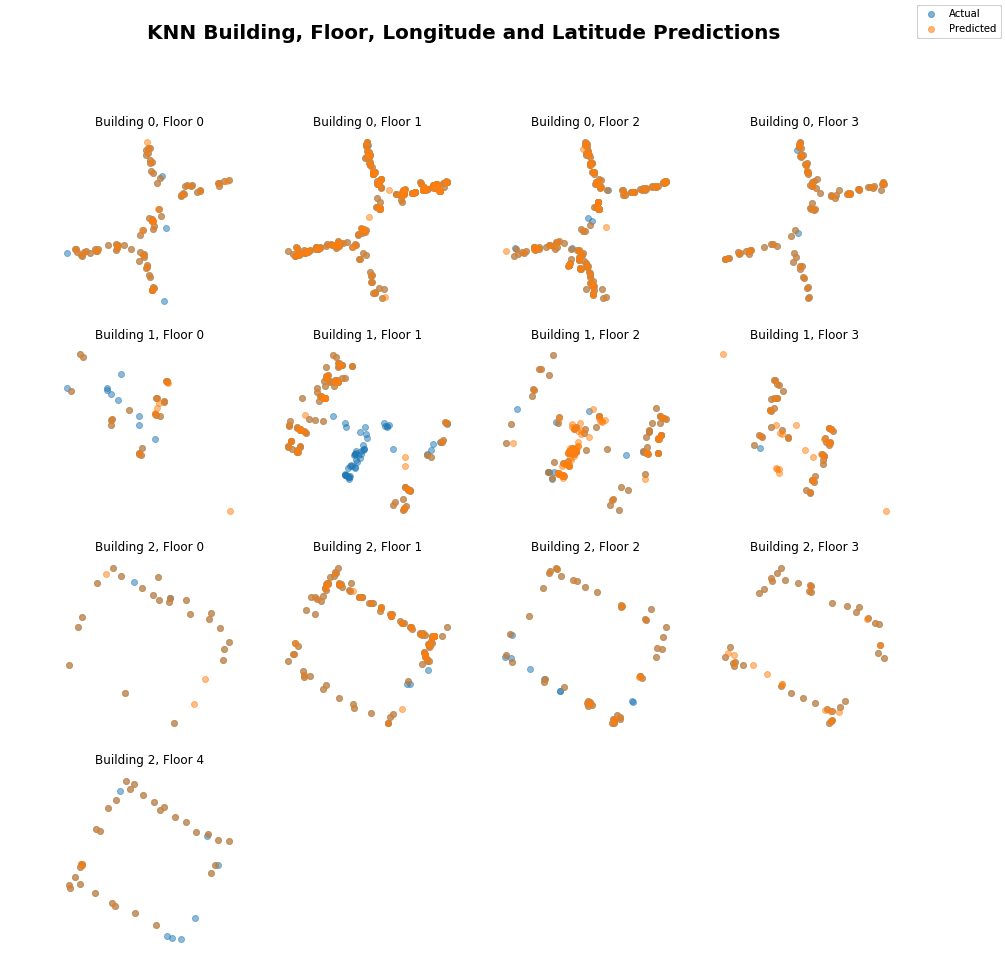

time: 1.82 s


In [61]:
subplot_num = 0
fig = plt.figure(figsize=(15,15))
fig.suptitle('KNN Building, Floor, Longitude and Latitude Predictions', fontsize=20, fontweight='bold')
for i in range(3):
    for j in np.unique(RF['FLOOR'][RF['BUILDINGID'] == i]):
        x, y = val_data['LONGITUDE'][val_data['BUILDINGID'] == i][val_data['FLOOR'] == j], val_data['LATITUDE'][val_data['BUILDINGID'] == i][val_data['FLOOR'] == j]
        x_p, y_p = KNN['LONGITUDE'][KNN['BUILDINGID'] == i][KNN['FLOOR'] == j], KNN['LATITUDE'][KNN['BUILDINGID'] == i][KNN['FLOOR'] == j]
        subplot_num += 1
        ax = fig.add_subplot(4,4,subplot_num)
        ax.set_title('Building %s, Floor %s' %(str(i),str(j)))
        plt.scatter(x,y, alpha=.5)
        plt.scatter(x_p, y_p, alpha=.5)
        plt.axis('off')
        fig.legend(['Actual', 'Predicted'])
fig.savefig('plots/KNN')

In [62]:
trace0 = go.Scatter3d(
    x=val_data['LATITUDE'][val_data['BUILDINGID'] == 0],
    y=val_data['LONGITUDE'][val_data['BUILDINGID'] == 0],
    z=val_data['FLOOR'][val_data['BUILDINGID'] == 0],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(0,0,150, 0.6)',                
        opacity=1
    ), name= 'Actual'
)

trace00 = go.Scatter3d(
    x=RF['LATITUDE'][RF['BUILDINGID'] == 0],
    y=RF['LONGITUDE'][RF['BUILDINGID'] == 0],
    z=RF['FLOOR'][RF['BUILDINGID'] == 0],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(255,0,0, 0.6)',                
        opacity=1
    ), name = 'Predicted'
)

trace1 = go.Scatter3d(
    x=val_data['LATITUDE'][val_data['BUILDINGID'] == 1],
    y=val_data['LONGITUDE'][val_data['BUILDINGID'] == 1],
    z=val_data['FLOOR'][val_data['BUILDINGID'] == 1],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(0,0,150, 0.6)',                
        opacity=1
    ), name= 'Actual'
)

trace11 = go.Scatter3d(
    x=RF['LATITUDE'][RF['BUILDINGID'] == 1],
    y=RF['LONGITUDE'][RF['BUILDINGID'] == 1],
    z=RF['FLOOR'][RF['BUILDINGID'] == 1],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(255,0,0, 0.6)',                
        opacity=1
    ), name = 'Predicted'
)

trace2 = go.Scatter3d(
    x=val_data['LATITUDE'][val_data['BUILDINGID'] == 2],
    y=val_data['LONGITUDE'][val_data['BUILDINGID'] == 2],
    z=val_data['FLOOR'][val_data['BUILDINGID'] == 2],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(0,0,150, 0.6)',                
        opacity=1
    ), name= 'Actual'
)

trace22 = go.Scatter3d(
    x=RF['LATITUDE'][RF['BUILDINGID'] == 2],
    y=RF['LONGITUDE'][RF['BUILDINGID'] == 2],
    z=RF['FLOOR'][RF['BUILDINGID'] == 2],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(255,0,0, 0.6)',                
        opacity=1
    ), name = 'Predicted'
)




datas = [trace0, trace00, trace1,trace11, trace2,trace22]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=datas, layout=layout)
py.iplot(fig, filename='simple-3d-scatter-2')

time: 2.07 s


In [63]:
trace0 = go.Scatter3d(
    x=val_data['LATITUDE'][val_data['BUILDINGID'] == 0],
    y=val_data['LONGITUDE'][val_data['BUILDINGID'] == 0],
    z=val_data['FLOOR'][val_data['BUILDINGID'] == 0],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(0,0,150, 0.6)',                
        opacity=1
    ), name= 'Actual'
)

trace00 = go.Scatter3d(
    x=KNN['LATITUDE'][KNN['BUILDINGID'] == 0],
    y=KNN['LONGITUDE'][KNN['BUILDINGID'] == 0],
    z=KNN['FLOOR'][KNN['BUILDINGID'] == 0],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(255,0,0, 0.6)',                
        opacity=1
    ), name = 'Predicted'
)

trace1 = go.Scatter3d(
    x=val_data['LATITUDE'][val_data['BUILDINGID'] == 1],
    y=val_data['LONGITUDE'][val_data['BUILDINGID'] == 1],
    z=val_data['FLOOR'][val_data['BUILDINGID'] == 1],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(0,0,150, 0.6)',                
        opacity=1
    ), name= 'Actual'
)

trace11 = go.Scatter3d(
    x=KNN['LATITUDE'][KNN['BUILDINGID'] == 1],
    y=KNN['LONGITUDE'][KNN['BUILDINGID'] == 1],
    z=KNN['FLOOR'][KNN['BUILDINGID'] == 1],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(255,0,0, 0.6)',                
        opacity=1
    ), name = 'Predicted'
)

trace2 = go.Scatter3d(
    x=val_data['LATITUDE'][val_data['BUILDINGID'] == 2],
    y=val_data['LONGITUDE'][val_data['BUILDINGID'] == 2],
    z=val_data['FLOOR'][val_data['BUILDINGID'] == 2],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(0,0,150, 0.6)',                
        opacity=1
    ), name= 'Actual'
)

trace22 = go.Scatter3d(
    x=KNN['LATITUDE'][KNN['BUILDINGID'] == 2],
    y=KNN['LONGITUDE'][KNN['BUILDINGID'] == 2],
    z=KNN['FLOOR'][KNN['BUILDINGID'] == 2],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(255,0,0, 0.6)',                
        opacity=1
    ), name = 'Predicted'
)




datas = [trace0, trace00, trace1,trace11, trace2,trace22]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=datas, layout=layout)
py.iplot(fig, filename='simple-3d-scatter-2')

time: 2.01 s
